# <center> NYC Climate Change - Analysis of Temperature Changes </center>

This independent study analyzes daily temperature data from six NYC weather stations over a ~72 year period (1951-2022) to identify whether daily temperatures have been changing over time. The research within this project was inspired by this [NYTimes article](https://www.nytimes.com/interactive/2018/05/03/learning/08WGOITGraphLN.html) which is based on [this paper](https://www.pnas.org/doi/epdf/10.1073/pnas.1205276109) by Dr. Hansen. The research techniques within this project are guided by the methods used in the paper.

### <center> Data Preparation </center>
The data for this study has been obtained from the National Oceanic and Atmospheric Administration (NOAA) website [here](https://www.ncei.noaa.gov/cdo-web/). The dataset contains ~72years worth of daily temperature data (Jan 1 1951 to Sep 30, 2022). Temperatures have been provided in Fahreinheit but since we generally talk about climate change in Celsius, e.g., impact of 2degree increase, etc., all temperatures are first converted to Celsius. 

For each day, the data contains a minimum (TMIN) and maximum (TMAX) temperature readings from between 1-5 weather stations that NOAA classifies under the New York County. The readings across the stations have been averaged to generate one daily minimum and maximum reading; these daily temperatures are further averaged to generate a daily average temperature (TAVG).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("NOAAClimateDate3107989.csv", parse_dates =[2])
df.sort_values("DATE", inplace = True)
df.head(2)
df.tail(2)


##Faehrenheit to Celsius
df["TMAX"] = df["TMAX"].apply(lambda x: (x-32)*5/9).round(2)
df["TMIN"] = df["TMIN"].apply(lambda x: (x-32)*5/9).round(2)

##generating a daily estimate by aggregating weather data from each station
df = df.groupby("DATE").agg({"TMAX":np.nanmean, "TMIN":np.nanmean}).reset_index()
df["TAVG"] =  np.nanmean(df[["TMAX","TMIN"]], axis = 1).round(2)

df.head(2)
df.tail(2)

,DATE,TMAX,TMIN,TAVG
26203,2022-09-28,20.56,11.67,16.11
26204,2022-09-29,18.89,11.67,15.28


### <center> Base Temperatures for Comparison </center> 

In order to analyze temperature changes, daily observed temperatures must be compared to some base daily value. 

As explained [here](https://www.ncei.noaa.gov/access/monitoring/dyk/anomalies-vs-temperature), generally, a 30year period would suffice as the "base period" as it is sufficiently long for meaningful statistical analysis. For this study, a 30year "base period" from 1953 to 1972<sup>1</sup> has been choosen  since "it was a time of relatively stable global temperature, prior to rapid global warming in recent decades" as referenced in Dr Hansen's research paper. 

The observed daily temperatures during this base period can then be averaged to calculate the daily base temperature for further analysis. For example, we would calculate the base temperature for Jan 1, as the average of the Jan 1 temperatures seen for every year in the base period, i.e., 30 days, one for each year from 1953 through 1982. We repeat this process for each day and in this way we will have 365 base temperatures, one for each day of the year.

In [2]:
##excluding data prior to 1953 per footnote 1
df = df[df["DATE"]>"1952-12-31"]


##calculating the base period and then calculating the daily average based on the temperatures seen in the base period
_ = df[(df["DATE"]>"1952-12-31") & (df["DATE"]<"1973-01-01")]
_["MM-DD"] = _["DATE"].apply(lambda x: x.strftime("%m-%d"))
_.head()
_.tail()

base = _.groupby("MM-DD").agg(Base_TMAX = ("TMAX",np.max),  
                              Base_TMIN = ("TMIN",np.min),  
                              Base_Avg = ("TAVG", np.mean)).round(2).reset_index()
base.head()
base.tail()

,MM-DD,Base_TMAX,Base_TMIN,Base_Avg
361,12-27,15.56,-10.00,0.70
362,12-28,15.84,-11.67,1.93
363,12-29,13.61,-7.22,1.31
364,12-30,11.11,-15.00,0.45
365,12-31,17.22,-15.56,0.50


### <center> Analysis and Comparison </center>

For the comparion component of this study, the data is divided into decades (see footnote 1) and we analyze the results of each decade separately in Fig. 1 and 2. For example, the Jan 1 temperature for each year in a decade is compared to the base Jan 1 temperature. We perform 365 such comparisons for each year and thus have 3650 readings for each decade.

<b> Fig. 1 </b> shows the range of the differences between the daily temperature for particular day in the decade compared with the base temperature for that day. If temperatures have remained relatively stable decade over decade, our expectation is that these differences in temperatures should be close to zero. For the first couple of decades, the temperature difference are centered around zero difference which is to be expected since the base period is built from these decades. Starting from ~1982 or so we see that the boxplots are shifting to the right meaning daily temperatures in that decade are generally higher than those for the corresponding day in the base period (positive differences).


In <b> Fig. 2 </b>, we also see the distribution shifting more to the right hand side of the histogram (implying positive differences when compared to the base period). We are also starting to see a general increase in the number of positive outliers, meaning unsually warm temperatures.




In [3]:
##Calculating the fluctuations in daily temperatures by comparing to the base period temperature for that day
df["MM-DD"] = df["DATE"].apply(lambda x: x.strftime("%m-%d"))
df = df.merge(base, left_on ="MM-DD", right_on ="MM-DD", how= "left")

df["Diff"] = df["TAVG"] - df["Base_Avg"]
df.head()
df.tail()


##adding decade information
df["YYYY"] = df["DATE"].apply(lambda x:x.year)

years = list(np.arange(1952,2023,10))
df["Decade"] = pd.cut(df["YYYY"],years) 
df.drop("YYYY", axis = 1, inplace = True)

df[["Decade","DATE","TAVG","Base_Avg","Diff"]].head(2)
# df.tail(2)

,Decade,DATE,TAVG,Base_Avg,Diff
0,"(1952, 1962]",1953-01-01,1.81,-0.09,1.90
1,"(1952, 1962]",1953-01-02,2.92,0.04,2.88


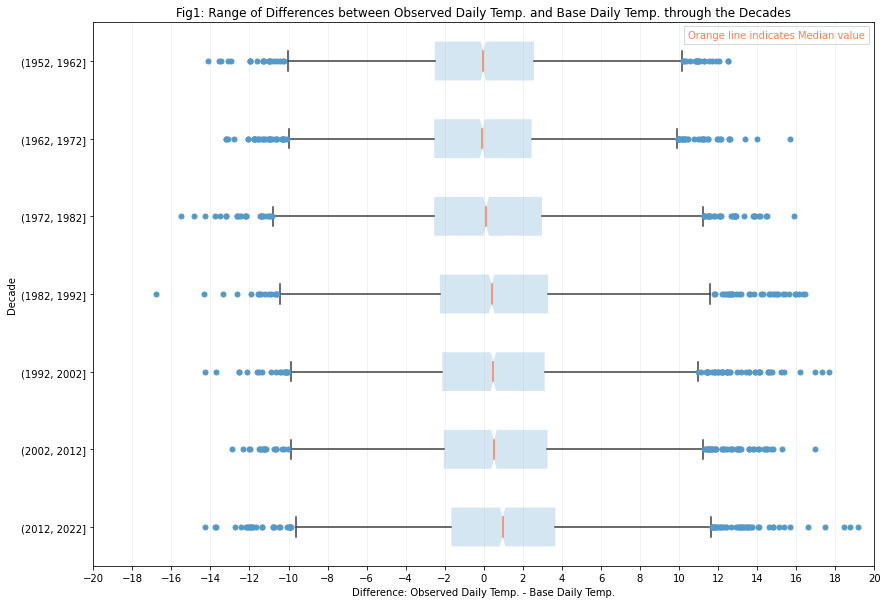

In [4]:
decades = [dec for dec in df["Decade"].unique()]


plt.figure(figsize = (14,10))
sns.boxplot(data= df, x = "Diff", y = "Decade", width = 0.5, notch = True,
            boxprops = {"facecolor" : "#D4E6F1", "edgecolor": "none"},
            flierprops = {"marker":"o", "markeredgecolor": "#5499C7","markerfacecolor" : "#5499C7"}, 
            medianprops={"color": "coral"}).set_title("Fig1: Range of Differences between Observed Daily Temp. and Base Daily Temp. through the Decades");
        
plt.xlabel("Difference: Observed Daily Temp. - Base Daily Temp.")
plt.grid(axis = "x", alpha = 0.2)

plt.text(19.5, -0.4, 'Orange line indicates Median value', color='coral',
        verticalalignment='top', horizontalalignment='right', 
         bbox={'edgecolor':'#AAB7B8', "facecolor": "#FDFEFE",'alpha':0.5,})

             
plt.xlim(-20,20)
plt.gca().set_xticks(np.arange(-20,21,2))
plt.savefig("Boxplots.png")

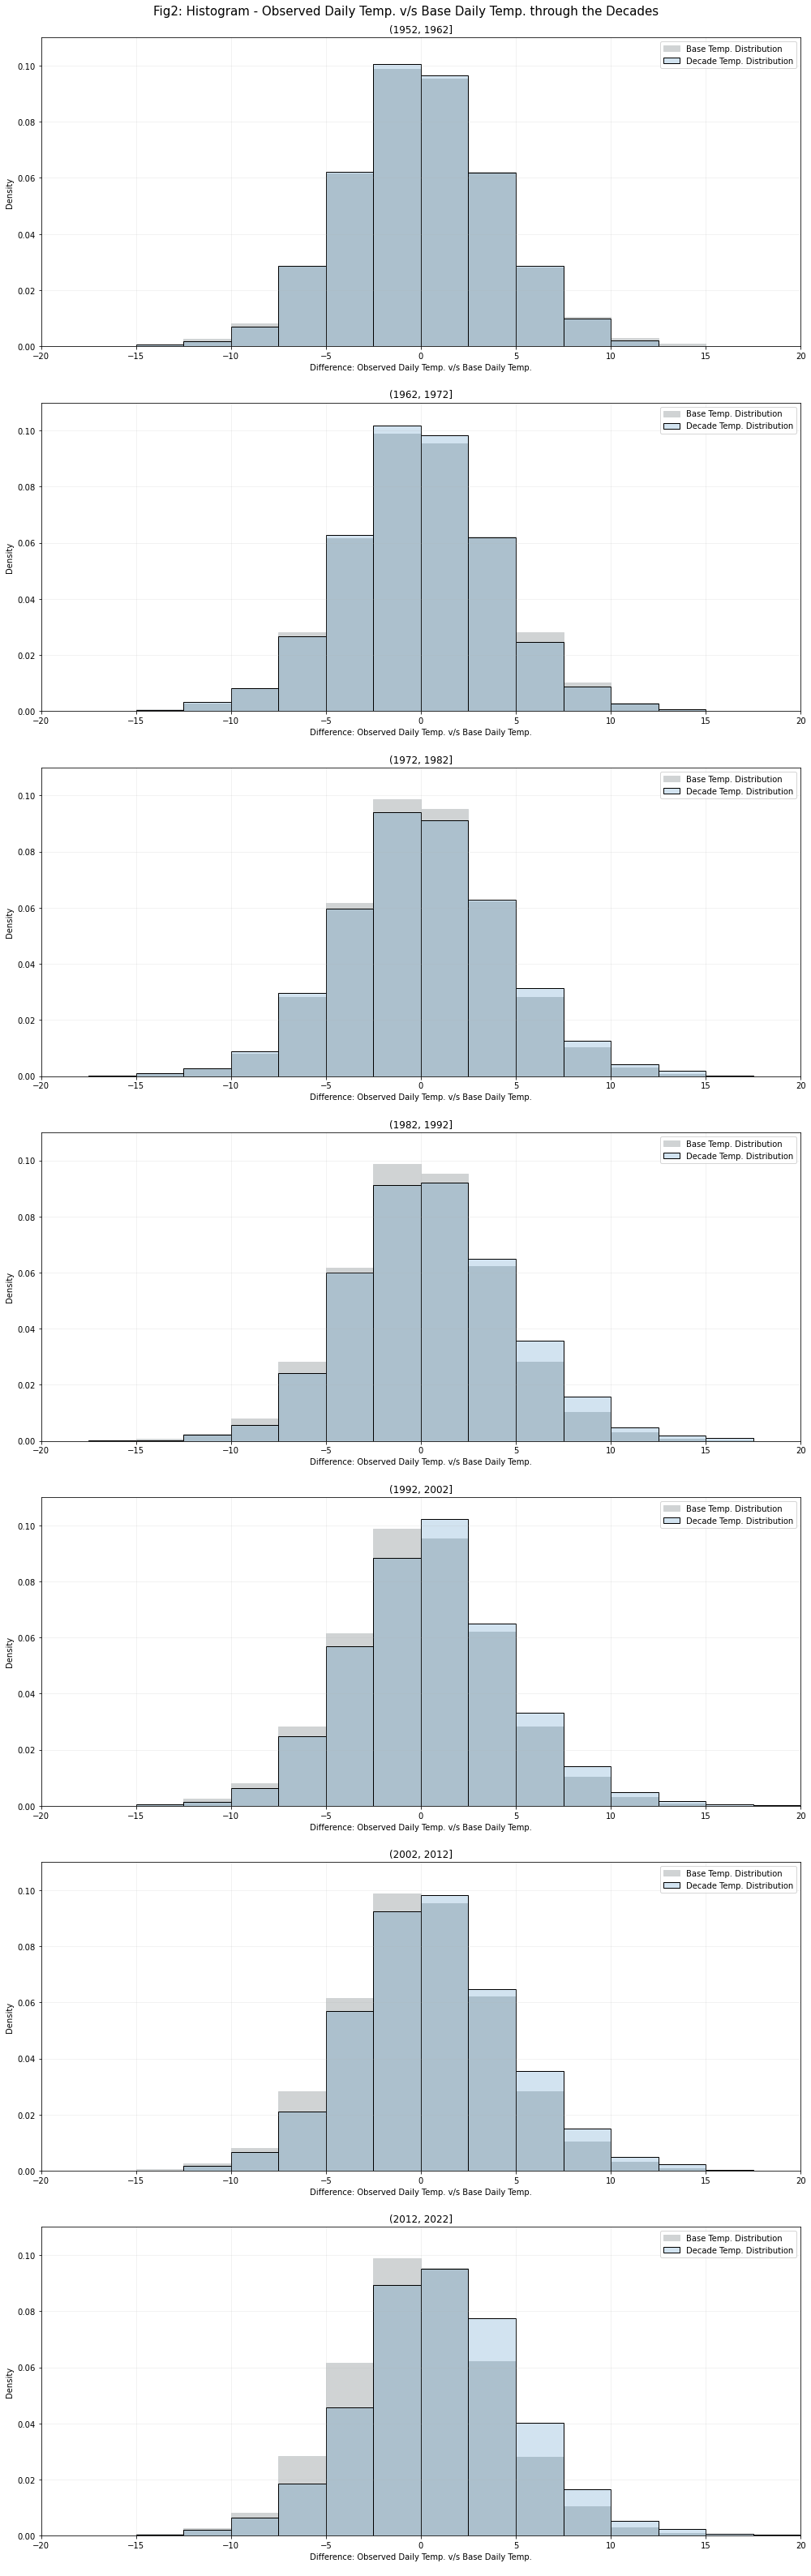

In [5]:
plt.figure(figsize = (14, 45))
i=1

b = df[df["Decade"].isin(decades[:3])]
   
    
for decade in decades:
    _ = df[df["Decade"]==decade]
    
    plt.subplot(7,1,i);
    sns.histplot(b["Diff"], stat = "density", bins = np.arange(-20,23,2.5),
                  facecolor = "#D0D3D4", edgecolor = "#D0D3D4",label = "Base Temp. Distribution");
    
    sns.histplot(_["Diff"], stat = "density", bins = np.arange(-20,23,2.5),
                 alpha = 0.2, label = "Decade Temp. Distribution").set_title(decade);
    
    plt.ylim(0,0.11);
    plt.gca().set_yticks(np.arange(0,0.11,0.02));
    plt.xlim(-20,20);
    plt.gca().set_xticks(np.arange(-20,21,5));

    plt.legend(loc = "best");

    plt.xlabel("Difference: Observed Daily Temp. v/s Base Daily Temp.\n");
    plt.grid(axis = "both", alpha = 0.2);
    i += 1
    
plt.suptitle("Fig2: Histogram - Observed Daily Temp. v/s Base Daily Temp. through the Decades\n\n\n", fontsize = 15);
plt.tight_layout()

plt.savefig('Histograms.png')

### <center>Additional Analysis: Outliers</center>

Creating a range based on the daily max and min temperatures seen in the base period (1953 to 1982). The Upper bound is the max of the daily  max temperatures seen in this base period. Similarly, the Lower Bound is the minimum of the daily min temperatures seen in this base period.

Outliers are any temperatures outside of this range in the comparison period. The daily max(min) temperature is calculated as the max(min) temperatures observed through the decade for that day. Through the decades, we see cooler temperature outliers decreasing compared to higher temperature outliers.

In [6]:
##creating the comparison dataset

df_agg = df.groupby(["Decade","MM-DD"]).agg(Decade_TMAX = ("TMAX", np.max), 
                                            Decade_TMIN = ("TMIN", np.min),
                                            Base_TMAX = ("Base_TMAX", np.mean),
                                            Base_TMIN = ("Base_TMIN", np.mean)).round(2).reset_index()

df_agg["High_outlier"] = df_agg["Decade_TMAX"] - df_agg["Base_TMAX"]
df_agg["High_outlier"] = df_agg["High_outlier"].apply(lambda x:max(x,0)).replace({0:np.NaN})
df_agg["High_outlier"] = df_agg["High_outlier"] + df_agg["Base_TMAX"]


df_agg["Low_outlier"] = df_agg["Decade_TMIN"] - df_agg["Base_TMIN"]
df_agg["Low_outlier"] = df_agg["Low_outlier"].apply(lambda x:min(x,0)).replace({0:np.NaN})
df_agg["Low_outlier"] = df_agg["Low_outlier"] + df_agg["Base_TMIN"]

df_agg.head(2)
df_agg.tail(2)

# df_agg[df_agg["High_outlier"].notna()].head(25)

,Decade,MM-DD,Decade_TMAX,Decade_TMIN,Base_TMAX,Base_TMIN,High_outlier,Low_outlier
2560,"(2012, 2022]",12-30,9.44,-8.33,11.11,-15.00,NaN,NaN
2561,"(2012, 2022]",12-31,12.78,-12.78,17.22,-15.56,NaN,NaN


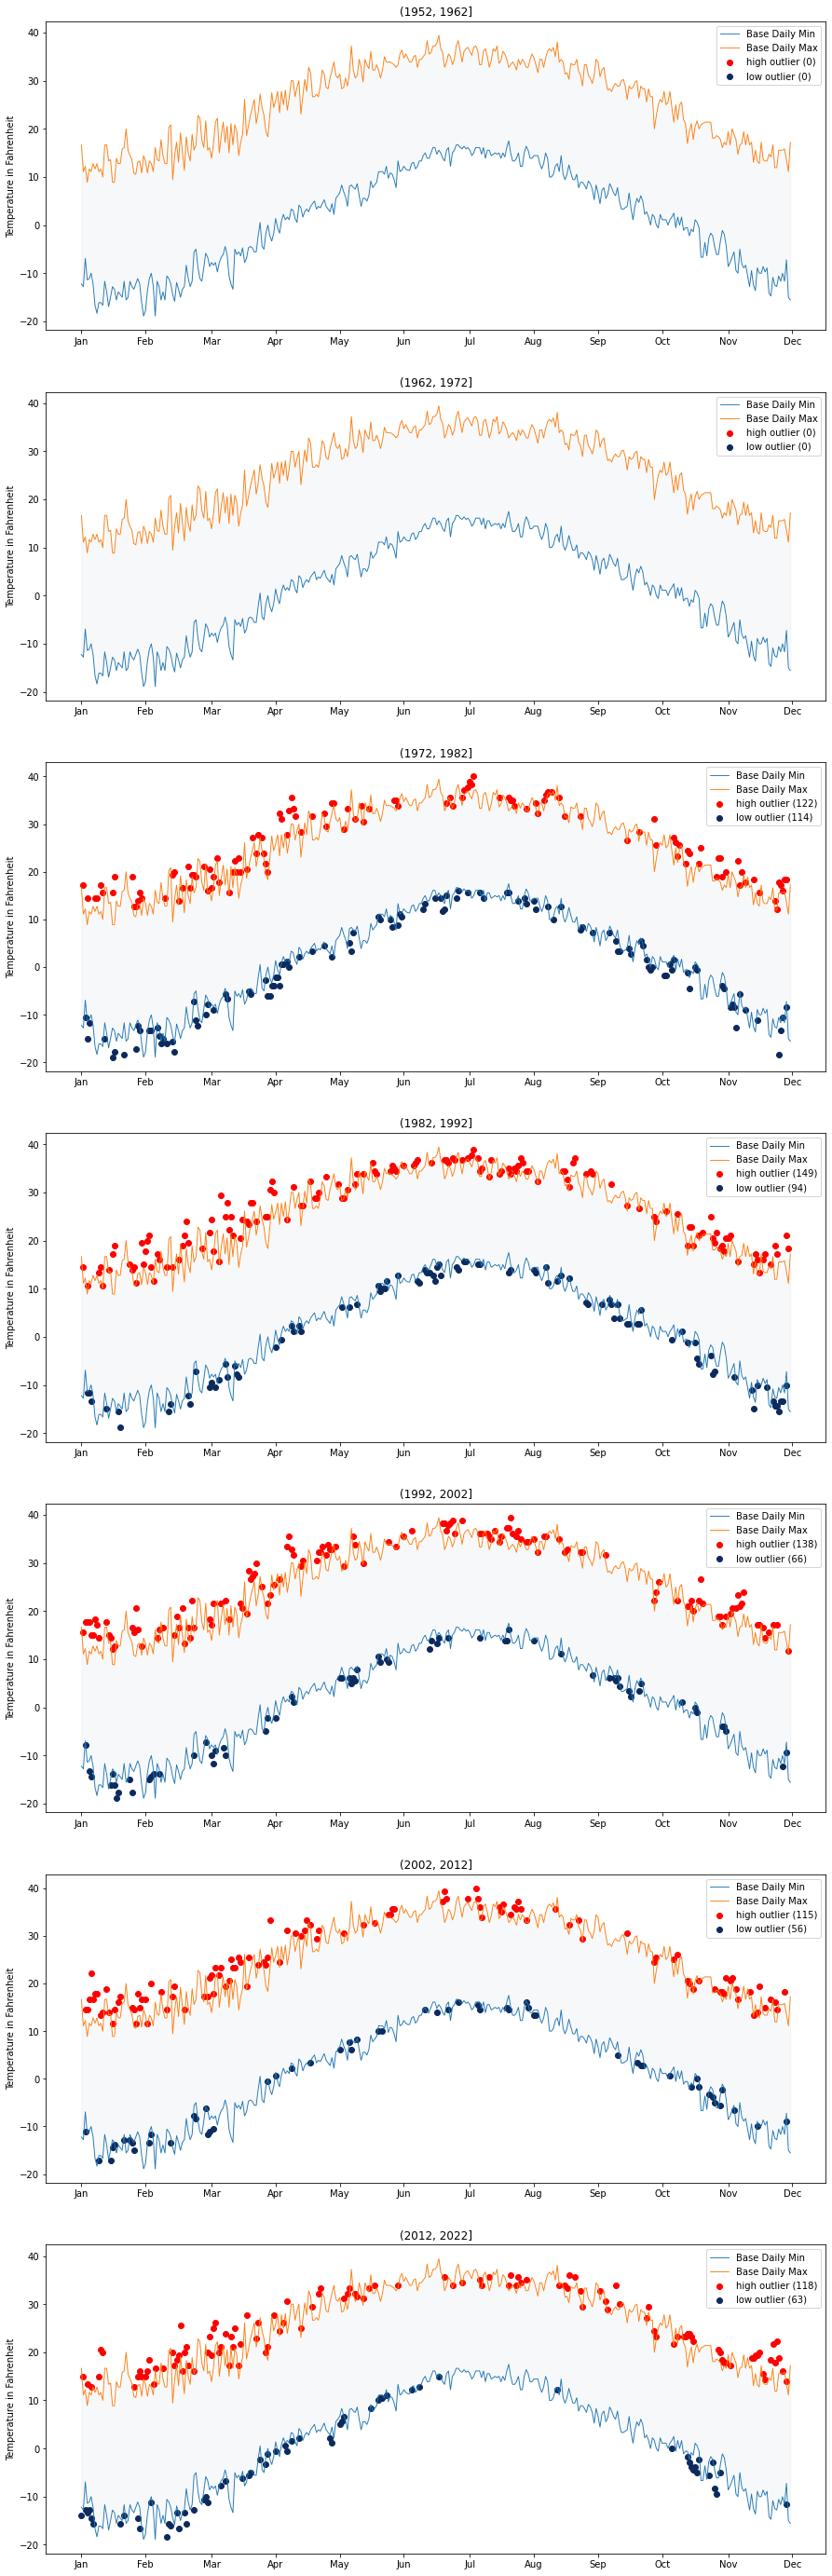

In [7]:
##plotting outliers
plt.figure(figsize=(15,50))
i=1
    
##plotting the comparison dataset
for decade in decades:
    
    _ = df_agg[df_agg["Decade"] == decade]
        
    plt.subplot(7,1,i)
                 
    plt.plot(base["Base_TMIN"], lw = 0.9, label = "Base Daily Min")
    plt.plot(base["Base_TMAX"], lw = 0.9, label = "Base Daily Max")

    plt.fill_between(base.index,base["Base_TMIN"],base["Base_TMAX"], color ="#d8dde6", alpha =0.2);

    plt.scatter(_["MM-DD"],_["High_outlier"], color ="red", label ="high outlier ("+str(_["High_outlier"].count())+")");
    plt.scatter(_["MM-DD"],_["Low_outlier"], color = "#0c2a5e",label ="low outlier ("+str(_["Low_outlier"].count())+")");

    plt.gca().set_xticks(np.linspace(0,366,12).round());
    plt.gca().set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]);
            
    plt.ylabel("Temperature in Fahrenheit");
    plt.legend(loc = "best");
    plt.title(decade)
        
    i += 1 
            
    plt.savefig("Outliers.png")

#### Reference Papers:

https://www.pnas.org/doi/epdf/10.1073/pnas.1205276109

https://www.climate-lab-book.ac.uk/2016/how-to-quantify-changes-in-climate-extremes-without-inducing-artefacts/

https://www.nytimes.com/interactive/2018/05/03/learning/08WGOITGraphLN.html

https://www.nytimes.com/interactive/2021/climate/extreme-summer-heat.html

    
    
#### Footnotes:
1: Note since our timeperiod ends in 2022, each decade in this study has be constructed as starting in the third year and ending in the second year.